# $D_S$ analysis

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from hstar import c6
from inference import stat

In [18]:
lumi = 3000.0

# cross-section x k-factor [fb]
ggzz2e2m = c6.Sample(k=1.83, xs=1.4783394, events=pd.read_csv('/raven/u/taepa/mcfm/MCFM-10.3/Bin/ggZZ2e2m_all/events.csv', nrows=100000))
ggzz4e = c6.Sample(k=1.83, xs=0.47412769, events=pd.read_csv('/raven/u/taepa/mcfm/MCFM-10.3/Bin/ggZZ4e_all/events.csv', nrows=100000))
ggzz4m = c6.Sample(k=1.83, xs=0.47412769, events=pd.read_csv('/raven/u/taepa/mcfm/MCFM-10.3/Bin/ggZZ4m_all/events.csv', nrows=100000))
ggzz2e2m.normalize(lumi)
ggzz4e.normalize(lumi)
ggzz4m.normalize(lumi)

# concatenate all events into one sample
events = pd.concat([ggzz2e2m.events, ggzz4e.events, ggzz4m.events])
sbi_ggzz = c6.Sample(k=1.83, xs=1.4783394+0.47412769+0.47412769, events = events)
sbi_ggzz.sm_msq_key = 'msq_gg_sm'
sbi_ggzz.c6_msq_map = {
  -5 : 'msq_gg_c6_6',
  -1 : 'msq_gg_c6_10',
  0 : 'msq_gg_c6_11',
  1 : 'msq_gg_c6_12',
  5 : 'msq_gg_c6_16'
}

# signal-only gg->h*->ZZ sample
# note: negative cross-section, because it doesn't matter!
sbi_gghzz = c6.Sample(xs=-99, events=events)
sbi_gghzz.sm_msq_key = 'msq_h_sm'
sbi_gghzz.c6_msq_map = {
    -5 : 'msq_h_c6_6',
    -1 : 'msq_h_c6_10',
    0 : 'msq_h_c6_11',
    1 : 'msq_h_c6_12',
    5 : 'msq_h_c6_16'
  }

sbi_uubzz = c6.Sample(xs=-99, events=events)
sbi_uubzz.sm_msq_key = 'msq_uub'

In [ ]:
import gc
del ggzz4e
del ggzz4m
del ggzz2e2m
gc.collect()

In [19]:
# c6 values
c6_vals = np.array([10.0, 20.0, 30.0])

# SM
sbi_ds_sm = np.log10(sbi_gghzz.msq() / (sbi_ggzz.msq() + 0.1*0.5*sbi_uubzz.msq()))
sbi_nu_sm = sbi_ggzz.nu(per_event=True)

# ME
sbi_msq_gghzz_c6 = sbi_gghzz.msq(c6_vals)
sbi_msq_ggzz_c6 = sbi_ggzz.msq(c6_vals)
sbi_ds_c6 = np.log10(sbi_msq_gghzz_c6 / (sbi_msq_ggzz_c6 + 0.1*0.5*(sbi_uubzz.msq())[:, np.newaxis]))

# event weight
sbi_nu_c6 = sbi_ggzz.nu(c6_vals,per_event=True)

/tmp/ipykernel_60830/124206740.py:5: RuntimeWarning: invalid value encountered in log10
  sbi_ds_sm = np.log10(sbi_gghzz.msq() / (sbi_ggzz.msq() + 0.1*0.5*sbi_uubzz.msq()))
/tmp/ipykernel_60830/124206740.py:11: RuntimeWarning: invalid value encountered in log10
  sbi_ds_c6 = np.log10(sbi_msq_gghzz_c6 / (sbi_msq_ggzz_c6 + 0.1*0.5*(sbi_uubzz.msq())[:, np.newaxis]))


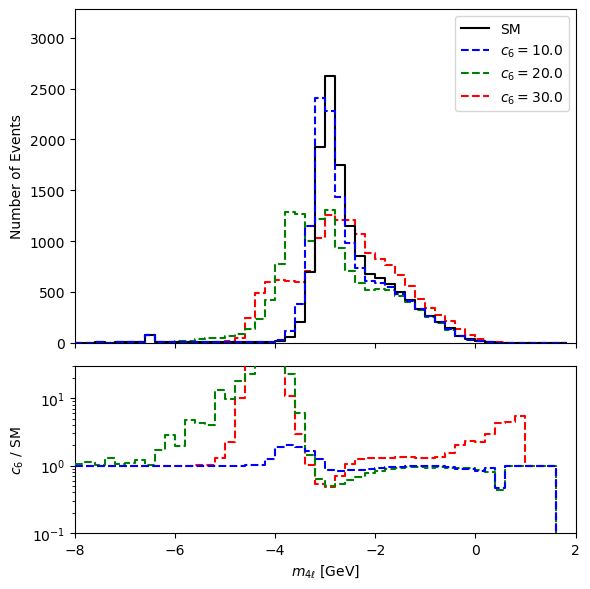

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=(2,1))

ds_bins = np.arange(-8,2.2,0.2)
ds_sm_centers = 0.5 * (ds_bins[1:] + ds_bins[:-1])

h_ds_sm, _ = np.histogram(sbi_ds_sm, bins=ds_bins, weights=sbi_nu_sm)
ax1.step(ds_bins[:-1], h_ds_sm, where='post', color='black', label='SM', zorder=10)

colors= 'bgrcmy'
for i, c6_val in enumerate(c6_vals):
  if np.isclose(c6_val, 0.0):
    continue
  h_ds_c6, _ = np.histogram(sbi_ds_c6[:, i], bins=ds_bins, weights=sbi_nu_c6[:, i])
  ax1.step(ds_bins[:-1], h_ds_c6, '--', color=colors[i], where='post', label=f'$c_6 = {c6_val}$', zorder=10-i)
  ratio = np.divide(h_ds_c6, h_ds_sm, out=np.zeros_like(h_ds_sm), where=h_ds_sm!=0)
  ax2.step(ds_bins[:-1], ratio, '--', color=colors[i],  where='post', label=f'$c_6 = {c6_val}$', zorder=10-i)


ax1.set_xlim(-8,2)
ax1.set_ylabel('Number of Events')
ax1.set_ylim(0, 1.25*np.max(h_ds_sm))
# ax1.set_yscale('log')
ax1.legend()

ax2.set_ylim(0.0,2.0)
ax2.set_xlabel('$m_{4\\ell}$ [GeV]')
ax2.set_ylabel('$c_6$ / SM')
ax2.set_ylim(1e-1,30.0)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

## $D_S$-based constraint on $c_6$

Now the task is to minimize
$$t_{c_6} = \prod_{i} \mathcal{P}( n_i(c_6) | \nu_i(c_6))$$

In [21]:
# define a finer grid for the scan
c6_pts = np.linspace(-20.0, 20.0, 201)

sbi_ds_sm = np.log10(sbi_gghzz.msq() / (sbi_ggzz.msq() + 0.1*0.5*sbi_uubzz.msq()))
sbi_nu_sm = sbi_ggzz.nu(per_event=True)
sbi_msq_gghzz_c6 = sbi_gghzz.msq(c6_pts)
sbi_msq_ggzz_c6 = sbi_ggzz.msq(c6_pts)
sbi_ds_c6 = np.log10(sbi_msq_gghzz_c6 / (sbi_msq_ggzz_c6 + 0.1*0.5*(sbi_uubzz.msq())[:, np.newaxis]))
sbi_nu_c6 = sbi_ggzz.nu(c6_pts,per_event=True)

ds_sm = sbi_ds_sm
nu_sm = sbi_nu_sm
ds_c6 = sbi_ds_c6
nu_c6 = sbi_nu_c6

/tmp/ipykernel_60830/1219862447.py:4: RuntimeWarning: invalid value encountered in log10
  sbi_ds_sm = np.log10(sbi_gghzz.msq() / (sbi_ggzz.msq() + 0.1*0.5*sbi_uubzz.msq()))
/tmp/ipykernel_60830/1219862447.py:8: RuntimeWarning: invalid value encountered in log10
  sbi_ds_c6 = np.log10(sbi_msq_gghzz_c6 / (sbi_msq_ggzz_c6 + 0.1*0.5*(sbi_uubzz.msq())[:, np.newaxis]))


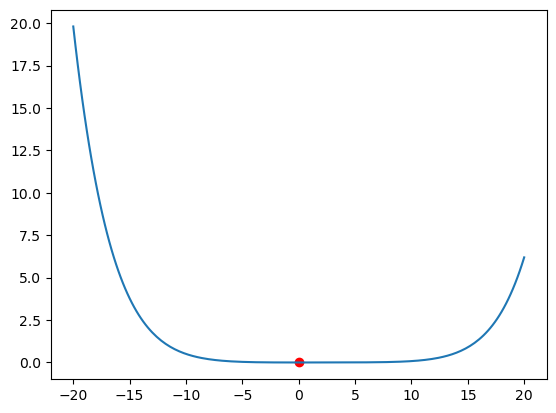

19.80868949151673


In [25]:
ds_bins = np.arange(-4.4,0.6,0.2)

# compute the nll
nll = np.zeros_like(c6_pts)
for i, c6_val in enumerate(c6_pts):
  h_ds_obs, _ = np.histogram(ds_sm, bins=ds_bins, weights=nu_sm)
  h_ds_exp, _ = np.histogram(ds_sm, bins=ds_bins, weights=nu_c6[:,i])
  nll[i] = stat.nll(h_ds_obs, h_ds_exp)
nll = nll - np.min(nll)

# find minimum
imin = np.argmin(nll)
nll_min = nll[imin]
c6_at_nll_min = c6_pts[imin]

# plot the scan + minimum
plt.plot(c6_pts, nll)
plt.scatter(c6_at_nll_min, nll_min, marker='o', color='red')
plt.show()

print(np.max(nll))

In [1]:
importlib.reload(stat)

# compute the nll
tc6 = np.zeros_like(c6_pts)
for i, c6_val in enumerate(c6_pts):
  h_ds_obs, _ = np.histogram(ds_c6[:,i], bins=ds_bins, weights=nu_sm)
  h_ds_exp, _ = np.histogram(ds_c6[:,i], bins=ds_bins, weights=nu_c6[:,i])
  tc6[i] = stat.nll(h_ds_obs, h_ds_exp) - stat.nll(h_ds_obs, h_ds_obs)

# find minimum
imin = np.argmin(tc6)
tc6_min = tc6[imin]
c6_at_nll_min = c6_pts[imin]

# plot the scan + minimum
plt.plot(c6_pts, tc6)
plt.scatter(c6_at_nll_min, nll_min, marker='o', color='red')
plt.show()

print(np.max(nll))

NameError: name 'importlib' is not defined

In [26]:
c6_pts = np.round(c6_pts, decimals = 1)
df = pd.DataFrame({'c6' : c6_pts, 'nll' : tc6})
df.to_csv('c6_nll_ds.csv', index=False)